<a href="https://colab.research.google.com/github/malekeechaker/CodeAlpha_Titanic_Classification/blob/main/Final_Task1_Titanic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240611%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240611T085154Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D158781ba6cdfece29cdeb7cc5fd4b4c2ff234373d37dbae25b95cc795dfc430e465f5df2150cfea730fa198a41b9104cc67c9d747060c9b3384e7ad32cc8a0c93d9c319d05b6a78103bbd768f15e5cf800b1e4788ade562701ec1d09ded73f12cbd49c1418ee43f23731d7c99ed2a9a5e10afc17a626d3a1062e170d307e3903eb16b7929914c51083a3e52135e5d62ff0b1899135571af7293914c1d9d0224ad92affa38ace0579a09194e3434ab0ef61672fce133538f7b7774b2ff6502e6e10c29f62b549eb5758721ce7abc003781fe6fae22b4da7159d44bfcdb8c4118fb56ca1df41bf5a92ba97ed664f5a02f34aded3197bede683c45db7bdd15265a0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')



# Task 1 Titanic Classification

## Import Libraries
Let's import some libraries to get started!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import seaborn as sns
%matplotlib inline

# Load Data


In [ ]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis


In [ ]:
train.shape

(891, 12)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Text(0.5, 1.0, 'Distribution of Survival on the Titanic')

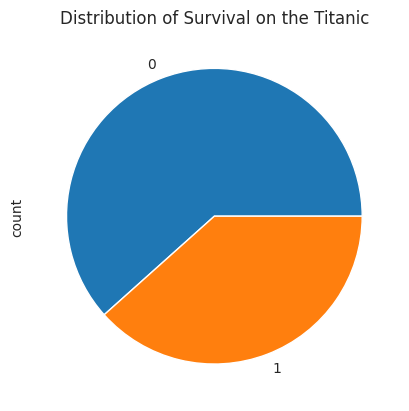

In [ ]:
train["Survived"].value_counts().plot(kind="pie")
plt.title('Distribution of Survival on the Titanic')

The data shows a significant imbalance between the two classes



*   Generate synthetic samples for the minority class SMOTE:.
*   Use methods like Random Forest or Gradient Boosting that can handle class imbalance more effectively.




Text(0.5, 1.0, 'Distribution of Sex on the Titanic')

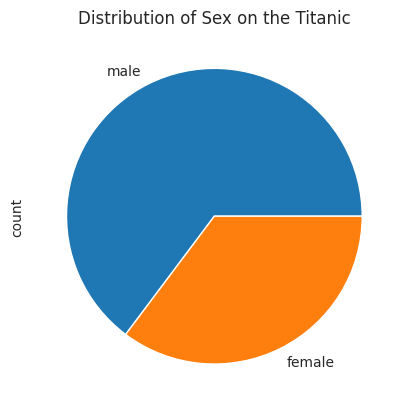

In [ ]:
train["Sex"].value_counts().plot(kind="pie")
plt.title('Distribution of Sex on the Titanic')

a significant imbalance between the Male and Female

<Axes: xlabel='Survived', ylabel='count'>

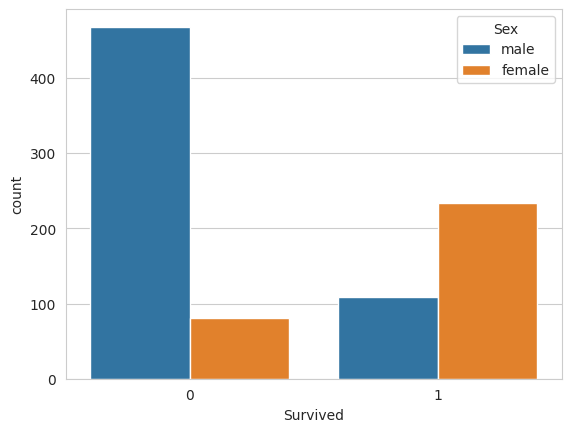

In [ ]:
sns.countplot(x='Survived',hue='Sex',data=train)

Most of the individuals who survived were female, while the majority of those who did not survive were male.

<Axes: xlabel='Survived', ylabel='count'>

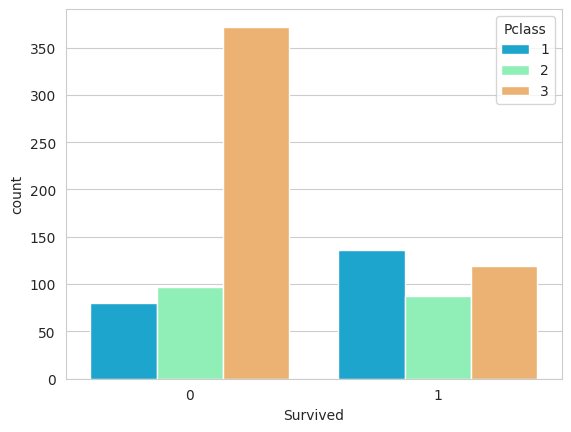

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<Axes: >

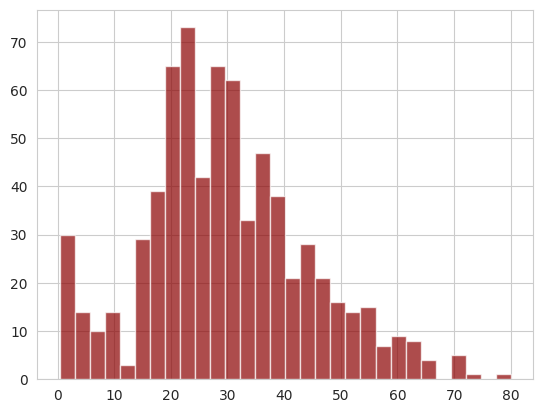

In [ ]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<Axes: xlabel='SibSp', ylabel='count'>

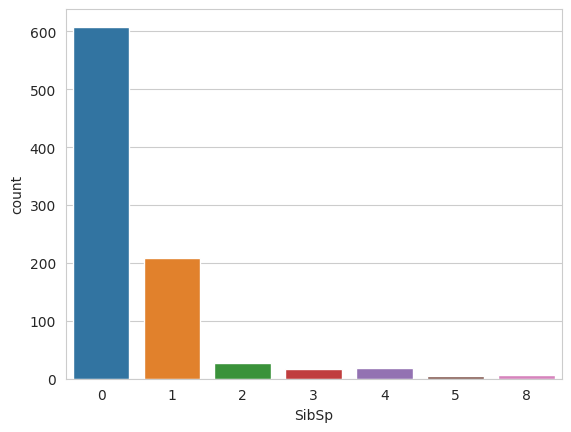

In [ ]:
sns.countplot(x='SibSp',data=train)

<Axes: xlabel='Parch', ylabel='count'>

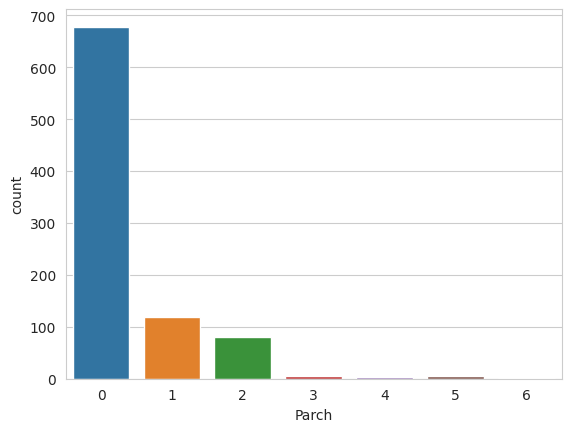

In [ ]:
sns.countplot(x='Parch',data=train)

<Axes: >

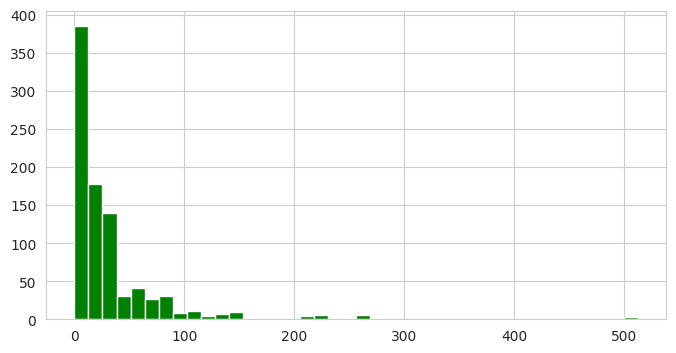

In [ ]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

**Missing Data**

We can use seaborn to create a simple heatmap to see where we are missing data!

<Axes: >

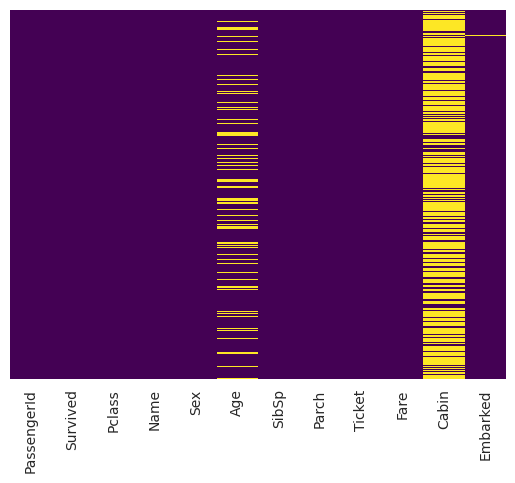

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

___
# Data Cleaning



we can drop the "Cabin" column with 77% missing values and replace le missing values of "Age" and "Embarked" column with the appropriate values

In [ ]:
train.drop('Cabin',axis=1,inplace=True)

<Axes: xlabel='SibSp', ylabel='Age'>

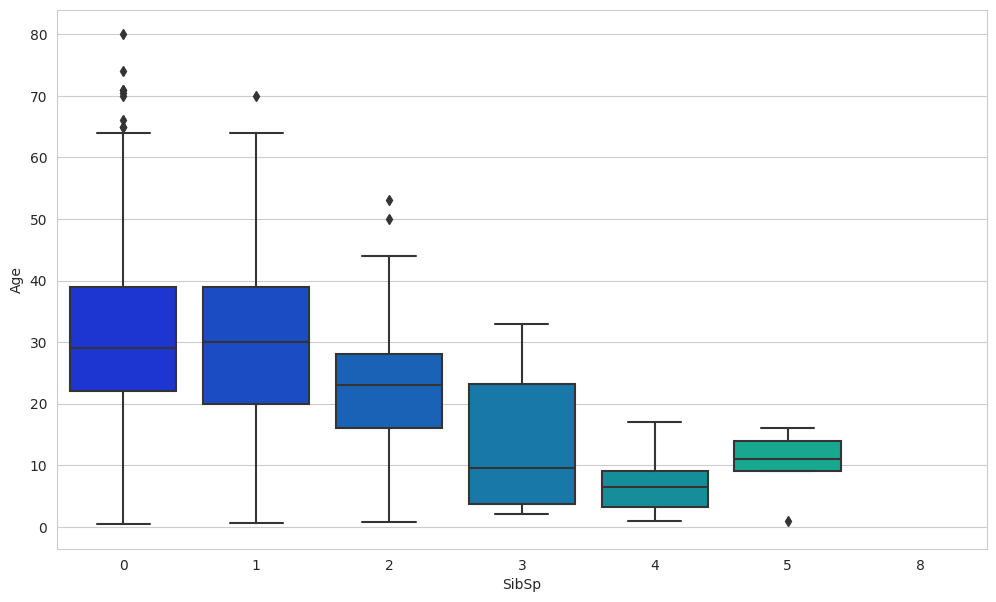

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='SibSp',y='Age',data=train,palette='winter')

We can observe a correlation between 'SibSp' (number of siblings/spouses aboard) and 'Age'. It is logical that if someone is traveling with more siblings, they are generally younger.

In [ ]:
Age_group = train['Age'].groupby(train['SibSp']).mean()
Age_group

SibSp
0    31.397558
1    30.089727
2    22.620000
3    13.916667
4     7.055556
5    10.200000
8          NaN
Name: Age, dtype: float64

A problem when SibSp == 8, there is no value for the Age.

-> Let's see the other columns

In [ ]:
train[train['SibSp']==8]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,S


In [ ]:
def impute_age(cols):
    Age = cols.iloc[0]
    SibSp = cols.iloc[1]

    if SibSp == 8:
      return train[(train["Pclass"] == 3)&(train["Parch"]==2)]["Age"].mean()
    else:
      return Age_group[SibSp]


Now apply that function!

In [ ]:
train['Age'] = train[['Age','SibSp']].apply(impute_age,axis=1)

And for the categorical column "Embarked", We're going to use the mode 'S'

In [ ]:
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)

/tmp/ipykernel_33/417421274.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)


Now let's check that heat map again!

<Axes: >

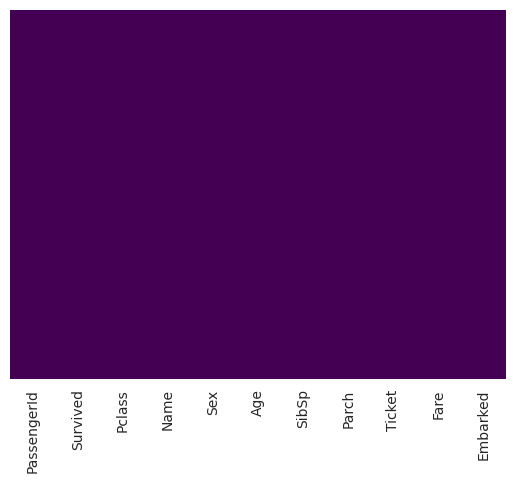

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,30.089727,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,30.089727,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,31.397558,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,30.089727,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,31.397558,0,0,373450,8.0500,S


# Converting Categorical Features
  We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [ ]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [ ]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [ ]:
train = pd.concat([train,sex,embark],axis=1)

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,30.089727,1,0,7.2500,True,False,True
1,2,1,1,30.089727,1,0,71.2833,False,False,False
2,3,1,3,31.397558,0,0,7.9250,False,False,True
3,4,1,1,30.089727,1,0,53.1000,False,False,True
4,5,0,3,31.397558,0,0,8.0500,True,False,True


** Great! Our data is ready for our model!**

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Survived'],axis=1),
                                                    train['Survived'], test_size=0.10,
                                                    random_state=101)

#Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predictions = logmodel.predict(X_test)
X_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
331,332,1,31.397558,0,0,28.500,True,False,True
700,701,1,30.089727,1,0,227.525,False,False,False
748,749,1,30.089727,1,0,53.100,True,False,True
751,752,3,31.397558,0,1,12.475,True,False,True
481,482,2,31.397558,0,0,0.000,True,False,True


In [ ]:
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1])


**Evaluation**

We can check precision,recall,f1-score using classification report!

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(confusion_matrix(y_test,predictions))

[[46  5]
 [15 24]]


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        51
           1       0.83      0.62      0.71        39

    accuracy                           0.78        90
   macro avg       0.79      0.76      0.76        90
weighted avg       0.79      0.78      0.77        90



# Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
svm_model = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')


In [ ]:
grid_search_svm.fit(X_train, y_train)

In [ ]:
grid_search_svm.best_params_

NameError: name 'grid_search_svm' is not defined

In [ ]:
grid_search_svm.best_estimator_

In [ ]:
predictions = grid_search_svm.predict(X_test)
predictions

In [ ]:
confusion_matrix(y_test,predictions)

In [ ]:
classification_report(y_test,predictions)

# Decision Tree Classifiction

Hyperparameter tuning using GridSearchCV with a DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
dt_model=DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train,y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
dt_pred = grid_search.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,dt_pred))

In [ ]:
print(classification_report(y_test,dt_pred))

# Random Forest Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf= RandomForestClassifier(n_estimators=500)
rf.fit(X_train,y_train)

In [ ]:
rf_pre=rf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,rf_pre))

In [ ]:
print(classification_report(y_test,rf_pre))

# XGBoosts Classifier

In [ ]:
from xgboost import XGBClassifier
xgboost = XGBClassifier(n_estimators=1000)
xgboost.fit(X_train,y_train)

In [ ]:
xg_pred = xgboost.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,xg_pred))

In [ ]:
print(classification_report(y_test,xg_pred))

# Atificiel Neural Network

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential

In [ ]:
ann  = Sequential()
ann.add(Dense(units= 32, kernel_initializer= 'uniform', activation = 'relu', input_dim=9))
ann.add(Dense(units= 32, kernel_initializer= 'uniform', activation = 'relu'))
ann.add(Dense(units= 1, kernel_initializer= 'uniform', activation = 'sigmoid'))
ann.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

X and y should be in float32 type to be treated in ANN

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [ ]:
ann.fit(X_train,y_train, batch_size=32, epochs=100,verbose= 0)

In [ ]:
ann_pred = ann.predict(X_test)
ann_pred = [ 1 if y>=0.5 else 0 for y in ann_pred]
print(ann_pred)

In [ ]:
print(confusion_matrix(y_test,ann_pred))

In [ ]:
print(classification_report(y_test,ann_pred))